## Importing

In [1]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
import _pickle as cPickle
import time
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

## Read dataset

In [2]:
df = pd.read_csv('movie_review.csv')

#### Drop useless columns

In [3]:
df = df.drop(columns=['fold_id', 'cv_tag', 'html_id', 'sent_id'])
df.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [4]:
df[df['tag'] == 'neg']

,text,tag
32937,"plot : two teen couples go to a church party ,...",neg
32938,they get into an accident .,neg
32939,"one of the guys dies , but his girlfriend cont...",neg
32940,what's the deal ?,neg
32941,"watch the movie and "" sorta "" find out . . .",neg
...,...,...
64715,that lack of inspiration can be traced back to...,neg
64716,like too many of the skits on the current inca...,neg
64717,"after watching one of the "" roxbury "" skits on...",neg
64718,"bump unsuspecting women , and . . . that's all .",neg


In [5]:
df_pos = df.iloc[:32937]
df_neg = df.iloc[32937:]

In [6]:
df_pos['tag'].value_counts()

pos    32937
Name: tag, dtype: int64

In [7]:
df_neg['tag'].value_counts()

neg    31783
Name: tag, dtype: int64

## Creating new DataFrame with only 1000 pos and 1000 neg tags

In [8]:
x = random.randint(0, 32000)

new_df_pos = df_pos[x:x+1000]
new_df_neg = df_neg[x:x+1000]
df = pd.concat([new_df_pos, new_df_neg])
df.reset_index(drop=True, inplace=True)
df.head()

,text,tag
0,""" you caress the noodles with the chopsticks ,...",pos
1,"of course , it's meant to be a parody , but th...",pos
2,you begin to appreciate the food as not merely...,pos
3,experiencing it is a process which engages all...,pos
4,"trust me , you really want to go find a noodle...",pos


## Cleaning text

In [9]:
def clean_text(text): # removing punctuation and lower the text
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for i in text: 
        if i in punc: 
            text = text.replace(i, "")
    text = text.lower()
    return text

In [10]:
df['text'] = df['text'].apply(clean_text)

## Encoding 'tag'

In [11]:
df['tag'] = df['tag'].apply(lambda x: 1 if x == "pos" else 0)

In [12]:
df['tag'].value_counts()

1    1000
0    1000
Name: tag, dtype: int64

## Spliting data into train and test set


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [14]:
with open('./train_dataset_1000.pickle', 'wb') as f:
    cPickle.dump(train, f)
    
with open('./test_dataset_1000.pickle', 'wb') as f:
    cPickle.dump(test, f)

## Tokenize text

In [15]:
all_text = ""
for i in range(len(train['text'])):
    all_text += train['text'].iloc[i]

In [16]:
# all_text

In [17]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [18]:
tokens = tokenize(all_text)

In [19]:
len(tokens)

30307

## Mapping, encode, decode functions

In [20]:
def mapping(tokens):
    word2id = {}
    id2word = {}
    
    for index, word in enumerate(set(tokens)):
        word2id[word] = index
        id2word[index] = word
    
    return word2id, id2word

In [21]:
word2id, id2word = mapping(tokens)

In [22]:
print(len(word2id))
print(len(id2word))

6227
6227


In [23]:
def encode_text(text):
    tokens = tokenize(text)
    encoded_text = []
    for token in tokens:
        if token in word2id:
            encoded_text.append(word2id[token])
    return encoded_text

In [24]:
def decode_text(encoded_text):
    decoded_text = []
    for index in encoded_text:
        decoded_text.append(id2word[index])
    return " ".join(decoded_text)

## Word2Vec class

In [25]:
class Word2Vec: # skip-gram model
    def __init__(self, n, eta, epochs, window_size):
        self.n = n # dimension of word embeddings (dimension of word's vector)
        self.eta = eta # learning rate
        self.epochs = epochs # number of epochs
        self.window = window_size # size of window context
    
    def generate_training_data(self, tokens, word2id):
        VOCAB_SIZE = len(word2id)
        tokens_len = len(tokens)
        training_data = []
        window = self.window
        self.v_count = VOCAB_SIZE
        print('Started generating data...')
        for i in range(tokens_len):
            
            X = self.one_hot_encode(word2id[tokens[i]], VOCAB_SIZE)
            
            if i % 1000 == 0:
                print(f'i: {i} in progres..')

            # left site of the word
            if i - window < 0:
                start = 0
            else:
                start = i - window

            # right site of the word

            if i + window + 1 > tokens_len:
                end = tokens_len
            else:
                end = i + window + 1

            idx = range(start, end)
            y = []
            for j in idx:
#                 if i % 1000 == 0:
#                     print(f'j: {j}')
                if i == j:
                    continue

                
                y.append(self.one_hot_encode(word2id[tokens[j]], VOCAB_SIZE))
            training_data.append([X, y])

        print("END. Now wait for converting list to numpy array..")
        return np.array(training_data, dtype=object)
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def one_hot_encode(self, id, vocab_size):
        vector = np.zeros(vocab_size)
        vector[id] = 1
        return list(vector)
    
    def forward(self, x):
        hidden = np.dot(self.w1.T, x)
        output = np.dot(self.w2.T, hidden)
        y_c = self.softmax(output)
        return y_c, hidden, output
    
    def backpropagation(self, e, h, x):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))

        # UPDATE WEIGHTS
        self.w1 = self.w1 - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
    
    def train(self, training_data, show_progress=True):
        print("\n Started training data..")
        self.w1 = np.random.uniform(-1, 1, (self.v_count, self.n))     # embedding matrix
        self.w2 = np.random.uniform(-1, 1, (self.n, self.v_count))     # context matrix
        history = []
        for i in range(self.epochs):
        
            self.loss = 0

            for target, context in training_data:

                    # FORWARD PASS
                    y_pred, hidden, output = self.forward(target)

                    # CALCULATE ERROR
                    EI = []
                    for word in context:
                        EI.append(np.subtract(y_pred, word))
                    EI = np.sum(EI, axis=0)
 
                    # BACKPROPAGATION
                    self.backpropagation(EI, hidden, target)

                    # CALCULATE LOSS
                    self.loss += -np.sum([output[word.index(1)] for word in context]) + len(context) * np.log(np.sum(np.exp(output)))
                
            history.append(self.loss)
            
            if show_progress:
                print(f'Epoch: {i}/{self.epochs}, Loss: {self.loss}')
        
        return history
        
    def get_vector(self, word, word2id):
        if word in word2id:
            w_index = word2id[word]
            v_w = self.w1[w_index]
            return v_w
        else:   
            return np.zeros(self.n)

In [26]:
len(tokens)

30307

## Generating training data

In [27]:
word2vec = Word2Vec(n=5, eta=0.01, epochs=25, window_size=2)

start_timer_data = time.perf_counter()

training_data = word2vec.generate_training_data(tokens, word2id)

end_timer_data = time.perf_counter()
print(f'Generating training data takes: {end_timer_data - start_timer_data}s')

Started generating data...
i: 0 in progres..
i: 1000 in progres..
i: 2000 in progres..
i: 3000 in progres..
i: 4000 in progres..
i: 5000 in progres..
i: 6000 in progres..
i: 7000 in progres..
i: 8000 in progres..
i: 9000 in progres..
i: 10000 in progres..
i: 11000 in progres..
i: 12000 in progres..
i: 13000 in progres..
i: 14000 in progres..
i: 15000 in progres..
i: 16000 in progres..
i: 17000 in progres..
i: 18000 in progres..
i: 19000 in progres..
i: 20000 in progres..
i: 21000 in progres..
i: 22000 in progres..
i: 23000 in progres..
i: 24000 in progres..
i: 25000 in progres..
i: 26000 in progres..
i: 27000 in progres..
i: 28000 in progres..
i: 29000 in progres..
i: 30000 in progres..
END. Now wait for converting list to numpy array..
Generating training data takes: 983.5025485000001s


## Training the model


 Started training data..
Epoch: 0/25, Loss: 1038129.2967818471
Epoch: 1/25, Loss: 947597.6032818429
Epoch: 2/25, Loss: 904864.5845315565
Epoch: 3/25, Loss: 880873.8732514392
Epoch: 4/25, Loss: 865059.336773856
Epoch: 5/25, Loss: 853713.744160605
Epoch: 6/25, Loss: 845220.326553488
Epoch: 7/25, Loss: 838675.9308172604
Epoch: 8/25, Loss: 833518.5447132502
Epoch: 9/25, Loss: 829385.4709698113
Epoch: 10/25, Loss: 826027.918076795
Epoch: 11/25, Loss: 823264.0142420788
Epoch: 12/25, Loss: 820955.9719816023
Epoch: 13/25, Loss: 818998.4535733201
Epoch: 14/25, Loss: 817310.9682925061
Epoch: 15/25, Loss: 815831.7237858712
Epoch: 16/25, Loss: 814513.1422572398
Epoch: 17/25, Loss: 813318.9560840062
Epoch: 18/25, Loss: 812221.9568607245
Epoch: 19/25, Loss: 811201.9450992192
Epoch: 20/25, Loss: 810243.9579686199
Epoch: 21/25, Loss: 809336.8251838592
Epoch: 22/25, Loss: 808472.0123908509
Epoch: 23/25, Loss: 807642.799271097
Epoch: 24/25, Loss: 806843.8464595656


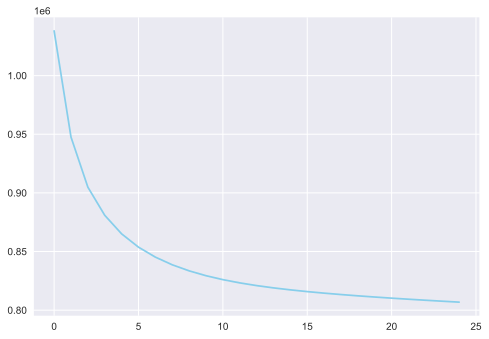

Saving completed model..
Training and saving the model takes: 21794.9712941s


In [29]:
start_timer_model = time.perf_counter()

history = word2vec.train(training_data, show_progress=True)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

print('Saving completed model..')
with open('./word2vec1000.pickle', 'wb') as f:
    cPickle.dump(word2vec, f)

end_timer_model = time.perf_counter()
print(f'Training and saving the model takes: {end_timer_model - start_timer_model}s')